In [1]:
%matplotlib inline
%run support.py
plt.style.use('~/Shared JupyterHub Notebooks/interactive.mplstyle')
#datafolder = "/mnt/Measurement_Data/phys-dots-26/Cooldown20200826" # I am saving all the data in a local folder to make it easier to share the data on zenodo.
datafolder = "./data/Measurements/Cooldown20200826"

In [2]:
vsd_arr, g_arr, Tmc_avg, Tmc_stddev = [], [], [], []
SD2dScans = [475, 477, 479, 481, 483, 485, 487, 489, 491]
for i,wn in enumerate(SD2dScans):
    filename = f"d{wn}_time_c12.h5"
    with h5py.File(f"{datafolder}/{filename}", 'r') as f:
        t = np.array(f['x_array'])
        v = np.array(f['y_array']) /1000  # v is in units of volts
        gCu = np.mean(np.array(f['gCu']), axis=1)
        #ICu = np.array(f['ICu'])
        metadata = json.loads(f['metadata'].attrs['sweep_logs'])
    gCu = 1/(1/gCu - 2*R_wire)
    vCu = v / ( 2*gCu*R_wire + 1 )
    #vCu = v * (1- 2*gCu*R_wire)
    t0 = datetime.datetime.strptime(metadata['time_started'], "%d/%m/%Y %H:%M:%S").timestamp()
    tf = datetime.datetime.strptime(metadata['time_completed'], "%d/%m/%Y %H:%M:%S").timestamp()
    #Tmc = GetBFData(6,t0,tf) # This procedure gets the data from the BF data server.
    #                          since I am sharing this notebook with the world, I have to save a local copy of the data
    #Tmc_avg.append([np.average(Tmc[:,1]), np.std(Tmc[:,1])])
    vsd_arr.append(vCu)
    g_arr.append(gCu)
#np.save(f"{datafolder}/calibration_BFdata.npy", np.array(Tmc_avg))  # I saved a local copy of the BF data from my network. Now we just load the local copy.
Tmc_avg = np.load(f"{datafolder}/calibration_BFdata.npy")

2.1683533093853707e-05 2.1683414161088876e-05 -1.8671853e-06


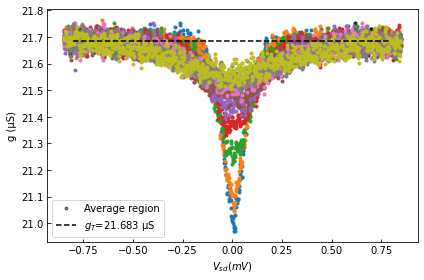

In [3]:
fig, ax = plt.subplots()
gT_avg = 0
N = len(vsd_arr)
for i in range(N):
    flt = np.abs(vsd_arr[i])>0.6*1e-3
    ax.plot(vsd_arr[i]*1e3, g_arr[i]*1e6, '.')
    gT_avg += np.average(g_arr[i][flt])
    if i==0:
        ax.plot(vsd_arr[i][flt]*1e3, g_arr[i][flt]*1e6, '.k', alpha=0.5, label='Average region')
    
gT_avg = gT_avg/N
ax.plot([-0.8, 0.8], [gT_avg*1e6]*2, '--k', label=f"$g_T$={gT_avg*1e6:.3f} µS")
ax.legend()
ax.set_xlabel(r"$V_{sd} (mV)$")
ax.set_ylabel("g (µS)")
print(gT_Cu, gT_avg, vsd_arr[0][0]-vsd_arr[0][1])

In [4]:
# Obtained from https://stackoverflow.com/questions/20339234/python-and-lmfit-how-to-fit-multiple-datasets-with-shared-parameters
def residual(params, vsd_arr, g_arr):
    """ calculate total residual for fits to several data sets held
    in a 2-D array, and modeled by Gaussian functions"""
    resid = []
    for i in range(len(vsd_arr)):
        Vsd0 = params[f'Vsd0_{i}'].value
        Te = params[f'Te_{i}'].value
        Ec = params[f'Ec'].value
        gT = params[f'gT'].value
        model = MasterEquation(vsd_arr[i], Vsd0, gT, Ec, Te, N=33)
        resid.extend((g_arr[i] - model))  #*1/(v[i]+1e-12*np.sign(v[i]))
    print(f"Ec={Ec:.6e} K", end="\r")
    resid = np.array(resid)
    resid[np.where(np.isnan(resid))[0]] = 0
    return resid

def GlobalFit(vsd_arr, g_arr):  # vsd_arr in units of Volts. g_arr in units of Siemens.
    fit_params = Parameters()
    for i, y in enumerate(vsd_arr):
        fit_params.add( f'Vsd0_{i}', value=0., min=-0.005, max=0.005)
        fit_params.add( f'Te_{i}', value=0.010 + i*0.004, min=0.005, max=0.055)

    fit_params.add( f'Ec', value=735e-6, min=700e-6, max=800e-6)
    fit_params.add( f'gT', value=gT_avg, vary=False)

    # run the global fit to all the data sets
    result = minimize(residual, fit_params, args=(vsd_arr, g_arr), method='powell') #, calc_covar=True) #, gtol=2.23e-16, ftol=2.23e-16, xtol=2.23e-16) differential_evolution
    return result

# Secondary thermometry fit function
def fitdg(T, Ec):
    u = 2*Ec/T
    return u/6 - u*u/60 + u*u*u/630

In [5]:
N = np.sum([vsd_arr[i].shape[0] for i in range(len(vsd_arr))])
result = GlobalFit(vsd_arr, g_arr)
if result.errorbars == False:
    print("Error bars could not be computed.")
    
Ec_fit = result.params[f"Ec"].value
gT_fit = result.params[f"gT"].value
print(f"Ec_fit={Ec_fit*1e6} µK, gT_fit={gT_fit*1e6} µS")
Te_arr = np.array([result.params[f"Te_{i}"].value for i in range(len(vsd_arr))])

v_fit = np.linspace(-750e-6, 750e-6, 201)
gME_arr, g0_globalfit = [], []
for i in range(len(vsd_arr)):
    gME_arr.append(MasterEquation(v_fit, result.params[f'Vsd0_{i}'].value, result.params[f'gT'].value, result.params[f'Ec'].value, result.params[f'Te_{i}'].value, N=33))
    g0_globalfit.append(np.min(gME_arr[i]))

Ec_fit=736.8152937932845 µK, gT_fit=21.683414161088876 µS


In [6]:
dg = 1 - np.array(g0_globalfit)/gT_avg

EcStars = []
start_fits = [1,2,3]
for start_fit in start_fits:
    popt, pcov = curve_fit(fitdg, Tmc_avg[start_fit:,0], dg[start_fit:], p0=[750e-6])
    EcStars.append(popt[0])

start_fit = 2
popt, pcov = curve_fit(fitdg, Tmc_avg[start_fit:,0], dg[start_fit:], p0=[750e-6])
EcStar = popt[0]
EcStar_err = np.max(EcStars) - np.min(EcStars)

print(f"Ec_star = {EcStar*1e6:.0f}+/-{EcStar_err*1e6:.0f} µK")
result

Ec_star = 764+/-36 µK


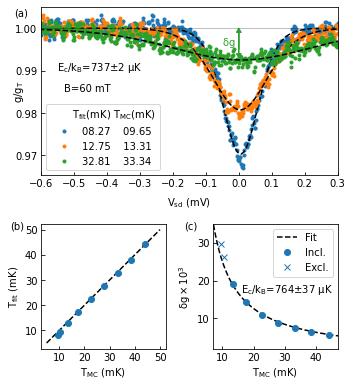

In [7]:
fig = plt.figure(figsize=(5, 5.5))
ax = []
ax.append(fig.add_subplot(211))
ax.append(fig.add_subplot(223))
ax.append(fig.add_subplot(224))
fig.tight_layout()

# Top panel
plot_indices = [0, 2, 6]
for ii, i in enumerate(plot_indices):
    ax[0].plot(vsd_arr[i]*1e3, g_arr[i]/gT_avg, '.', color=colors[ii], label=f"{Te_arr[i]*1e3:05.2f}    {Tmc_avg[i,0]*1e3:05.2f}") # , alpha=0.5
    ax[0].plot(v_fit*1e3, gME_arr[i]/gT_avg, '--k')
    
ax[0].text(-0.55, 0.990, f"$\mathrm{{E_c/k_B}}$={result.params[f'Ec'].value*1e6:.0f}$\pm$2 µK")  # result.params['Ec'].stderr*1e6:.0f
ax[0].text(-0.53, 0.985, f"B=60 mT")
ax[0].legend(title="       $\mathrm{T_{fit} (mK)}$ $\mathrm{T_{MC} (mK)}$")
ax[0].set_xlim(-0.6, 0.3)
ax[0].set_yticks(np.linspace(0.97, 1, 4))

ax[0].plot([np.min(v_fit)*1e3, np.max(v_fit)*1e3], [1,1], '-k', alpha=0.5, lw=0.5)
ax[0].arrow(0, 0.999, 0, -0.005, head_width=0.015, head_length=0.001, fc=colors[2], ec=colors[2])
ax[0].arrow(0, 0.999-0.004, 0, 0.004, head_width=0.015, head_length=0.001, fc=colors[2], ec=colors[2])
ax[0].text(-0.05, 0.996, r'$\mathrm{\delta g}$', color=colors[2])

ax[0].set_xlabel(r'$\mathrm{V_{sd}}$ (mV)')
ax[0].set_ylabel(r'$\mathrm{g/g_T}$')
ax[0].xaxis.set_label_coords(0.5,-0.12)
ax[0].yaxis.set_label_coords(-.05,.5)


# Bottom left
ax[1].errorbar(Tmc_avg[:,0]*1e3, [result.params[f'Te_{i}'].value*1e3 for i in range(len(Tmc_avg[:,0]))], linestyle='', marker='o', xerr=Tmc_avg[:,1]*1e3)
ax[1].plot([5, 50], [5, 50], 'k--')
ax[1].set_xlabel(r'$\mathrm{T_{MC}}$ (mK)')
ax[1].set_ylabel(r'$\mathrm{T_{fit}}$ (mK)')
ax[1].set_aspect('equal')
ax[1].set_xticks([10,20,30,40,50])
ax[1].set_yticks([10,20,30,40,50])

# Bottom right
T_fit = np.linspace(5e-3, 50e-3, 101)
ax[2].plot(T_fit*1e3, fitdg(T_fit, EcStar)*1e3, '--k', label='Fit')

ax[2].plot(Tmc_avg[start_fit:,0]*1e3, dg[start_fit:]*1e3, 'o', color=colors[0], label='Incl.')
ax[2].plot(Tmc_avg[:start_fit,0]*1e3, dg[:start_fit]*1e3, 'x', color=colors[0], label='Excl.')

ax[2].text(16, 17, f"$\mathrm{{E_c/k_B}}$={EcStar*1e6:.0f}$\pm${np.ceil(EcStar_err*1e6):.0f} µK")

ax[2].set_ylabel(r'$\mathrm{\delta g \times 10^3}$')
ax[2].set_xlabel(r'$\mathrm{T_{MC}}$ (mK)');
ax[2].set_xlim(7,47)
ax[2].set_ylim(2,35)
x0,x1 = ax[2].get_xlim()
y0,y1 = ax[2].get_ylim()
ax[2].set_aspect((x1-x0)/(y1-y0))
ax[2].legend()

ax[0].text(-0.68, 1.003, '(a)')
ax[1].text(-0.25, 0.96, '(b)', transform=ax[1].transAxes)
ax[2].text(-0.23, 0.96, '(c)', transform=ax[2].transAxes)

fig.savefig("calibration.pdf", bbox_inches = 'tight', pad_inches = 0)

# Add a low temperature source-drain bias to the calibration traces

In [8]:
#filename = f"d525_c12.h5"
#filename = f"d531_c12.h5"
filename = f"d638_c12.h5"
with h5py.File(f"{datafolder}/{filename}", 'r') as f:
    v = np.array(f['x_array']) /1000  # v is in units of volts
    gCu = np.array(f['gCu'])

gCu_lowT = 1/(1/gCu - 2*R_wire)
vCu_lowT = v / ( 2*gCu*R_wire + 1 )
#lowestT = Tcbt_Cu(np.min(gCu_lowT)/gT_avg, Ec_Cu*1e-3)
lowestT = Tcbt_Cu(np.mean(gCu_lowT[int(gCu_lowT.shape[0]/2)+1:int(gCu_lowT.shape[0]/2)+6])/gT_avg, Ec_Cu*1e-3)

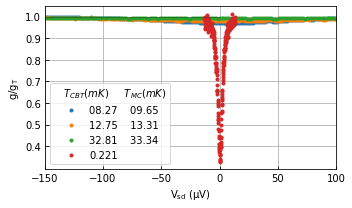

In [9]:
fig, ax = plt.subplots(figsize=(5,3))

for ii, i in enumerate(plot_indices):
    ax.plot(vsd_arr[i]*1e6, g_arr[i]/gT_avg, '.', color=colors[ii], label=f"{Te_arr[i]*1e3:05.2f}    {Tmc_avg[i,0]*1e3:05.2f}") # , alpha=0.5
    #ax.plot(v_fit*1e6, gME_arr[i]/gT_avg, '--k')
    
ax.plot(vCu_lowT*1e6, gCu_lowT/gT_avg, '.', color=colors[len(plot_indices)], label=f"{lowestT*1e3:05.3f}")
#ME = MasterEquation(vCu_lowT, 0, gT=gT_avg, Te=0.392e-3, Ec=Ec_Cu*1e-3)
#ax.plot(vCu_lowT*1e6, ME/gT_avg, '--r')

#ax.text(-0.55, 0.990, f"$\mathrm{{E_c}}$={result.params[f'Ec'].value*1e6:.0f} µK")  # $\pm${result.params['Ec'].stderr*1e6:.0f}
#ax.text(-0.53, 0.985, f"B=60 mT")
ax.legend(title="   $T_{CBT} (mK)$     $T_{MC} (mK)$")
ax.set_xlim(-150, 100)
ax.set_yticks(np.linspace(0.4, 1, 7))

ax.plot([np.min(v_fit)*1e6, np.max(v_fit)*1e3], [1,1], '-k', alpha=0.5, lw=0.5)
#ax.arrow(0, 0.999, 0, -0.005, head_width=0.015, head_length=0.001, fc=colors[2], ec=colors[2])
#ax.arrow(0, 0.999-0.004, 0, 0.004, head_width=0.015, head_length=0.001, fc=colors[2], ec=colors[2])
#ax.text(-0.05, 0.996, r'$\mathrm{\delta g}$', color=colors[2])

ax.set_xlabel(r'$\mathrm{V_{sd}}$ (µV)')
ax.set_ylabel(r'$\mathrm{g/g_T}$')
#ax.xaxis.set_label_coords(0.5,-0.12)
#ax.yaxis.set_label_coords(-.05,.5)
ax.grid()

fig.savefig("LowTemperatureTrace.pdf", bbox_inches = 'tight', pad_inches = 0.05)